In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import MSELoss

from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)
# torch.set_default_dtype(torch.float16)


cuda


## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

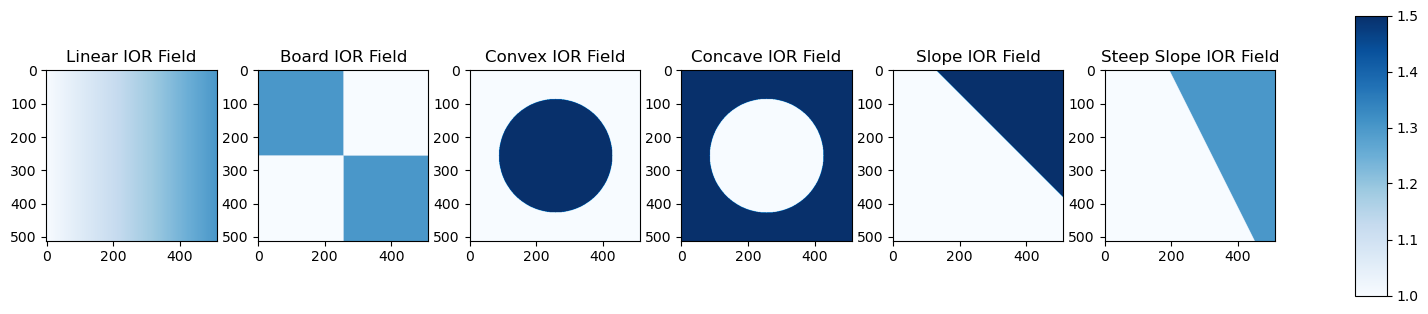

In [2]:
field_size = 512

height, width = field_size, field_size
gradient = np.linspace(0, 0.3, width, dtype=np.float32)
linear_ior_field = np.tile(gradient, (height, 1)) + 1

tile_size = int(field_size / 2)
board_ior_field = np.kron([[1, 0] * (width//tile_size//2),
                 [0, 1] * (width//tile_size//2)] * (height//tile_size//2),
                np.ones((tile_size, tile_size))) * 0.3 + 1.0

center = (height//2, width//2)
radius = int(field_size / 3) 
y, x = np.ogrid[:height, :width]
mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
convex_lens_ior_field = np.ones((height, width), dtype=np.float32)
convex_lens_ior_field[mask] = 1.5

concave_lens_ior_field = np.ones((height, width), dtype=np.float32) * 1.5
concave_lens_ior_field[mask] = 1.0


slope_ior_field = np.zeros((height, width), dtype=np.float32)
for y in range(height):
    for x in range(width):
        if y < x - int(field_size / 4):
            slope_ior_field[y, x] = 1.5
        else:
            slope_ior_field[y, x] = 1.0

steep_slope_ior_field = np.zeros((height, width), dtype=np.float32)
for y in range(height):
    for x in range(width):
        if y < 2 * x - int(field_size * 0.75):
            steep_slope_ior_field[y, x] = 1.3
        else:
            steep_slope_ior_field[y, x] = 1.0

plt.figure(figsize=(16, 4))

ior_fields = [linear_ior_field, board_ior_field, convex_lens_ior_field, concave_lens_ior_field, slope_ior_field, steep_slope_ior_field]
titles = ['Linear IOR Field', 'Board IOR Field', 'Convex IOR Field', 'Concave IOR Field', 'Slope IOR Field', 'Steep Slope IOR Field']

for i, field in enumerate(ior_fields, 1):
    plt.subplot(1, 6, i)
    plt.imshow(field, cmap='Blues', vmin=1.0, vmax=1.5)
    plt.title(titles[i - 1])

# Share the same colorbar
plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)

plt.show()

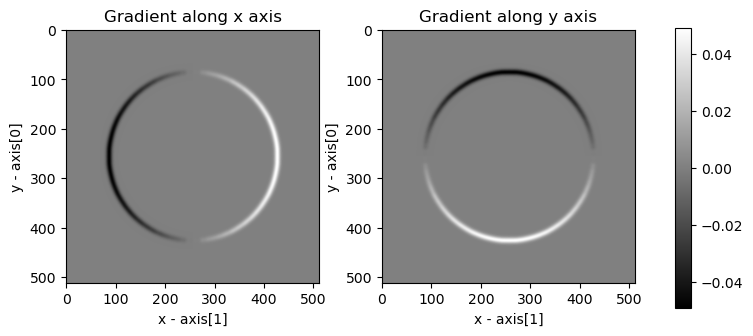

In [3]:
def compute_gradients(IOR: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    
    smoothed_ior = gaussian_filter(IOR, sigma=4.0)


    grad_x = np.gradient(smoothed_ior, axis=1)
    grad_y = np.gradient(smoothed_ior, axis=0)
    return grad_x, grad_y

grad_x, grad_y = compute_gradients(concave_lens_ior_field)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient along x axis')
plt.xlabel('x - axis[1]')
plt.ylabel('y - axis[0]')

plt.subplot(122)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient along y axis')

plt.xlabel('x - axis[1]')
plt.ylabel('y - axis[0]')

plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)
plt.show()

## 2. Adaptive wavefront propagation

In [4]:
class Patch:
    def __init__(self, start_pos: np.ndarray, end_pos: np.ndarray, 
                 start_dir: np.ndarray, end_dir: np.ndarray, energy: float):
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.start_dir = start_dir
        self.end_dir = end_dir
        self.energy = energy
    
    def mid_pos(self):
        return (self.start_pos + self.end_pos) / 2
    
    def length(self):
        return np.linalg.norm(self.end_pos - self.start_pos)
    
    def __repr__(self):
        return (f"Patch - start_pos{self.start_pos.tolist()}, "
                f"end_pos{self.end_pos.tolist()} | "
                f"start_dir{self.start_dir.tolist()}, "
                f"end_dir{self.end_dir.tolist()} | "
                f"mid_pos{self.mid_pos().tolist()} | "
                f"energy={self.energy}, "
                f"length={self.length()}")

# Initialize wavefront using Patch class
initial_wavefront_positions = [(0, i) for i in range(field_size)]  # initial positions are on the left edge
initial_wavefront_directions = [(1, 0) for _ in range(field_size)]  # initial directions are all to the right

initial_wavefront_patches = []
for i in range(field_size - 1):
    start_pos = np.array(initial_wavefront_positions[i])
    end_pos = np.array(initial_wavefront_positions[i + 1])
    start_dir = np.array(initial_wavefront_directions[i])
    end_dir = np.array(initial_wavefront_directions[i + 1])
    energy = 1.0  # Initial energy of each patch
    patch = Patch(start_pos, end_pos, start_dir, end_dir, energy)
    initial_wavefront_patches.append(patch)

num_steps = int(field_size * 3)
delta_t = 0.6
num_show_images = 3

ior_field_dict = {
    'linear': {'ior': linear_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    'board': {'ior': board_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    'convex_lens': {'ior': convex_lens_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    'concave_lens': {'ior': concave_lens_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    # 'slope': {'ior': slope_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None},
    # 'steep_slope': {'ior': steep_slope_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None}
}

### (1) Patch-based wavefront propagation

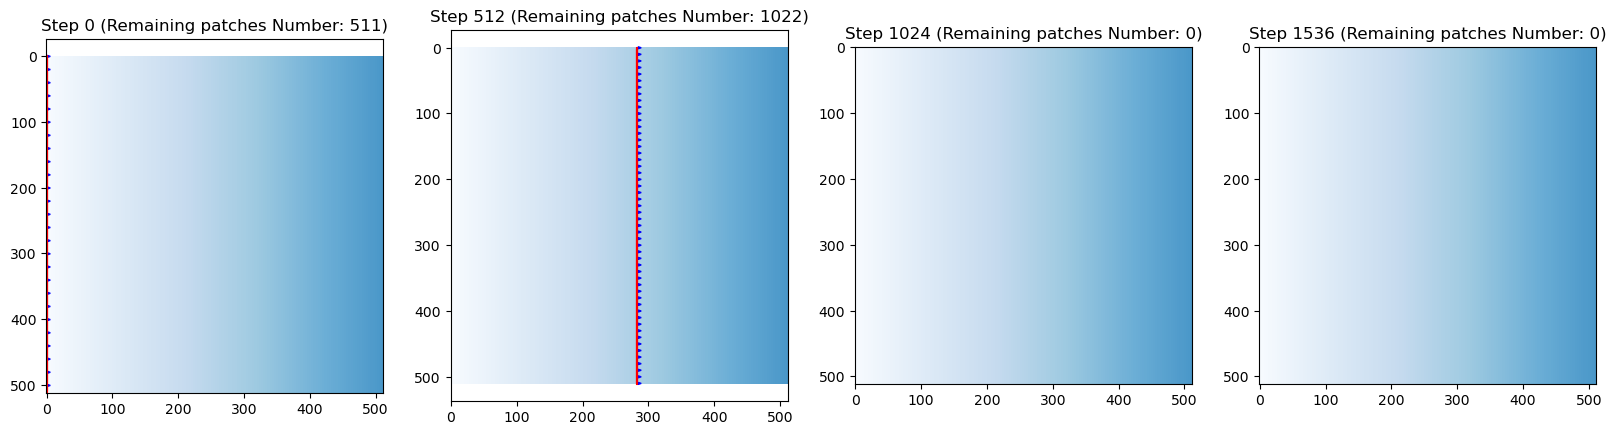

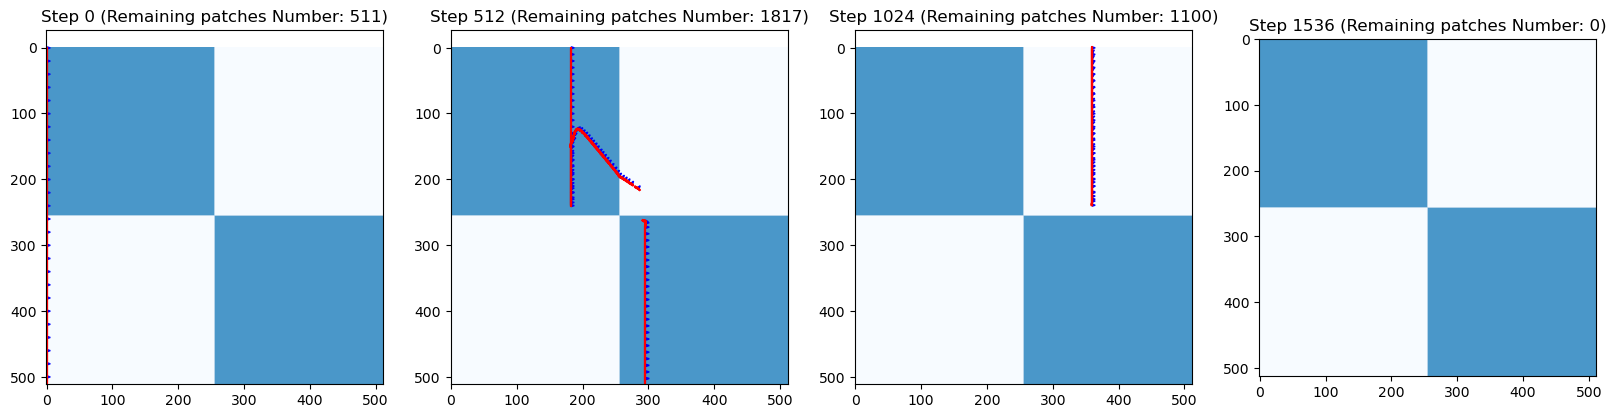

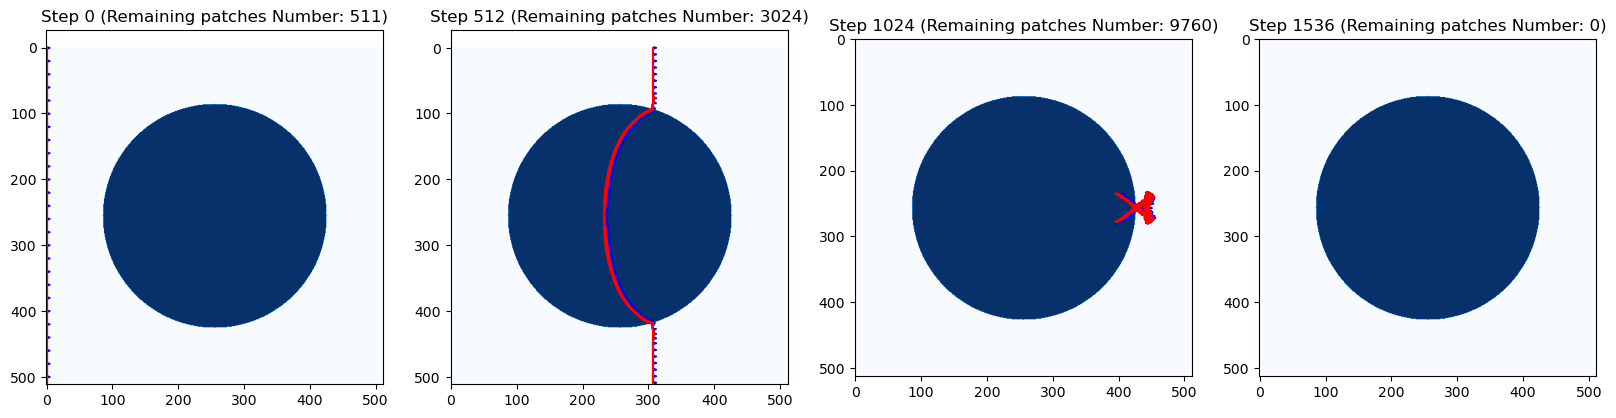

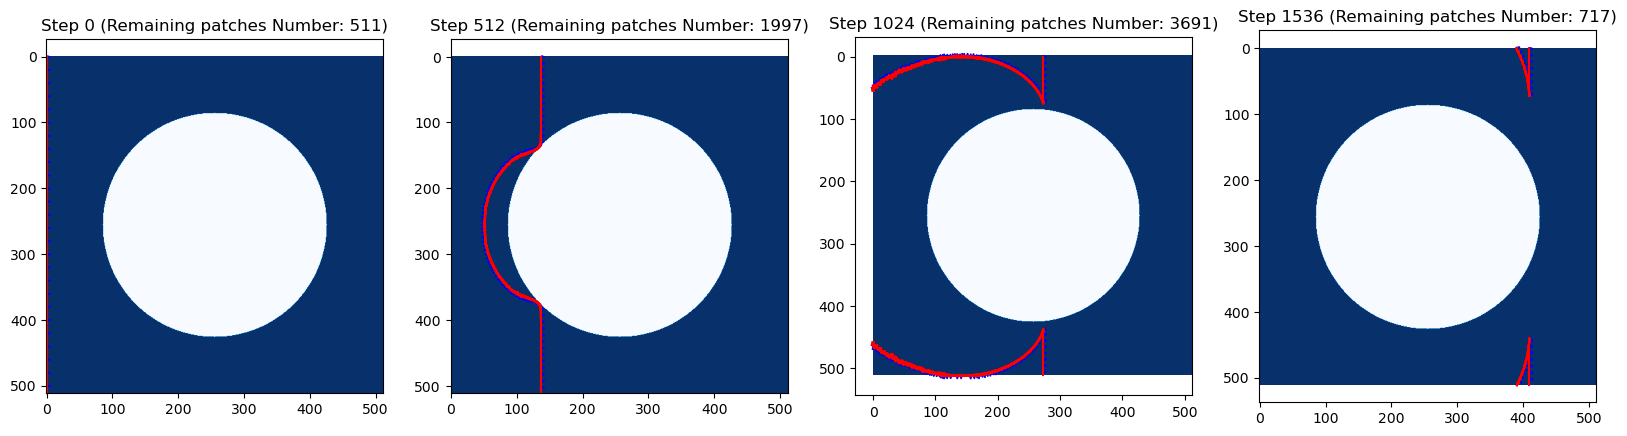

In [5]:
def update_wavefront_patches(patches: list[Patch], IOR: np.ndarray, IOR_grad: tuple[np.ndarray, np.ndarray], delta_t: float, refine_threshold: float = 0.5, energy_threshold: float = 0.002) -> list[Patch]:
    new_patches = []
    grad_x_ior, grad_y_ior = IOR_grad
    
    for patch in patches:
        # Split patches until all patches are smaller than the refine_threshold
        patch_queue = [patch]
        while patch_queue:
            current_patch = patch_queue.pop(0)
            start_x, start_y = current_patch.start_pos
            end_x, end_y = current_patch.end_pos
            start_vx, start_vy = current_patch.start_dir
            end_vx, end_vy = current_patch.end_dir

            if current_patch.energy < energy_threshold:
                continue  # Eliminate the patch and continue with the next one

            if np.linalg.norm([end_x - start_x, end_y - start_y]) > refine_threshold:
                # If the patch is too long, split it into two smaller patches
                mid_x = (start_x + end_x) / 2
                mid_y = (start_y + end_y) / 2
                mid_vx = (start_vx + end_vx) / 2
                mid_vy = (start_vy + end_vy) / 2

                new_patch_1 = Patch(np.array([start_x, start_y]), np.array([mid_x, mid_y]),
                                    np.array([start_vx, start_vy]), np.array([mid_vx, mid_vy]),
                                    current_patch.energy / 2)
                new_patch_2 = Patch(np.array([mid_x, mid_y]), np.array([end_x, end_y]),
                                    np.array([mid_vx, mid_vy]), np.array([end_vx, end_vy]),
                                    current_patch.energy / 2)
                patch_queue.append(new_patch_1)
                patch_queue.append(new_patch_2)
            else:
                if (0 <= int(start_y) < IOR.shape[0] and 0 <= int(start_x) < IOR.shape[1] and
                    0 <= int(end_y) < IOR.shape[0] and 0 <= int(end_x) < IOR.shape[1]):

                    start_n = IOR[int(start_y), int(start_x)]
                    end_n = IOR[int(end_y), int(end_x)]
                    start_nx = grad_x_ior[int(start_y), int(start_x)]
                    start_ny = grad_y_ior[int(start_y), int(start_x)]
                    end_nx = grad_x_ior[int(end_y), int(end_x)]
                    end_ny = grad_y_ior[int(end_y), int(end_x)]

                    # x_i+1 = x_i + delta_t * v_i / n^2
                    # Calculate the new positions
                    new_start_x = start_x + delta_t * (start_vx / (start_n**2))
                    new_start_y = start_y + delta_t * (start_vy / (start_n**2))
                    new_end_x = end_x + delta_t * (end_vx / (end_n**2))
                    new_end_y = end_y + delta_t * (end_vy / (end_n**2))
                    # v_i+1 = v_i + delta_t * grad_n / n
                    # Calculate the new directions
                    new_start_vx = start_vx + delta_t * (start_nx / start_n)
                    new_start_vy = start_vy + delta_t * (start_ny / start_n)
                    new_end_vx = end_vx + delta_t * (end_nx / end_n)
                    new_end_vy = end_vy + delta_t * (end_ny / end_n)

                    new_patch = Patch(np.array([new_start_x, new_start_y]), np.array([new_end_x, new_end_y]),
                                      np.array([new_start_vx, new_start_vy]), np.array([new_end_vx, new_end_vy]),
                                      current_patch.energy)
                    new_patches.append(new_patch)

    return new_patches

def simulate_wavefront_propagation_patches(cur_IOR: np.ndarray, initial_wavefront_patches: list[Patch], num_steps=200, delta_t=1.0) -> list[list[Patch]]:
    wavefront_patch_list = [initial_wavefront_patches]
    cur_IOR_grad = compute_gradients(cur_IOR)
    for _ in range(num_steps):
        new_patches = update_wavefront_patches(wavefront_patch_list[-1], cur_IOR, cur_IOR_grad, delta_t)
        wavefront_patch_list.append(new_patches)
    return wavefront_patch_list

def visualize_wavefront_propagation_patches(wavefront_patch_list: list[list[Patch]], 
                                    cur_IOR: np.ndarray, num_show_images=5):
    # show the wavefront propagation in num_show_images steps between 0 and num_steps
    num_steps = len(wavefront_patch_list) - 1
    num_show_images = [i for i in range(0, num_steps + 1, num_steps // num_show_images)]

    plt.figure(figsize=(5 * len(num_show_images), 5))
    for i in num_show_images:
        plt.subplot(1, len(num_show_images), num_show_images.index(i) + 1)
        plt.imshow(cur_IOR, cmap='Blues', vmin=1.0, vmax=1.5)
        
        for j, patch in enumerate(wavefront_patch_list[i]):
            start_pos = patch.start_pos
            end_pos = patch.end_pos
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], color='red')            
            if j % 20 == 0:
                mid_pos = patch.mid_pos()
                plt.arrow(mid_pos[0], mid_pos[1], patch.start_dir[0], patch.start_dir[1], color='blue', head_width=3)
        
        plt.title(f'Step {i} (Remaining patches Number: {len(wavefront_patch_list[i])})')
    plt.show()

for key, value in ior_field_dict.items():
    wavefront_patches = simulate_wavefront_propagation_patches(value['ior'], initial_wavefront_patches, num_steps, delta_t)
    value['patches_list'] = wavefront_patches
    visualize_wavefront_propagation_patches(wavefront_patches, value['ior'], num_show_images)

### (2) Point-based wavefront propagation

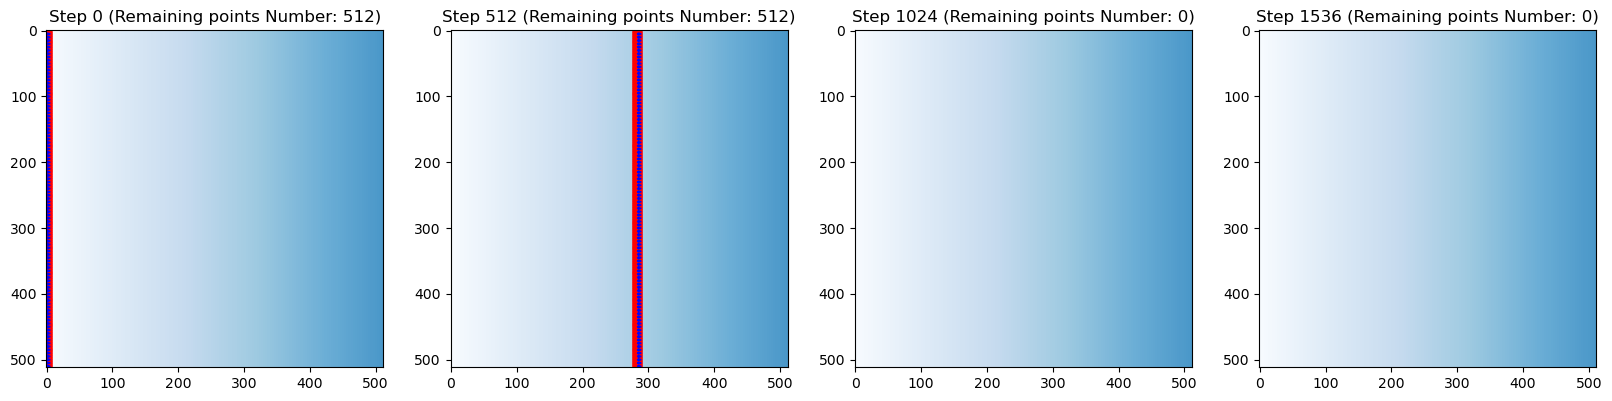

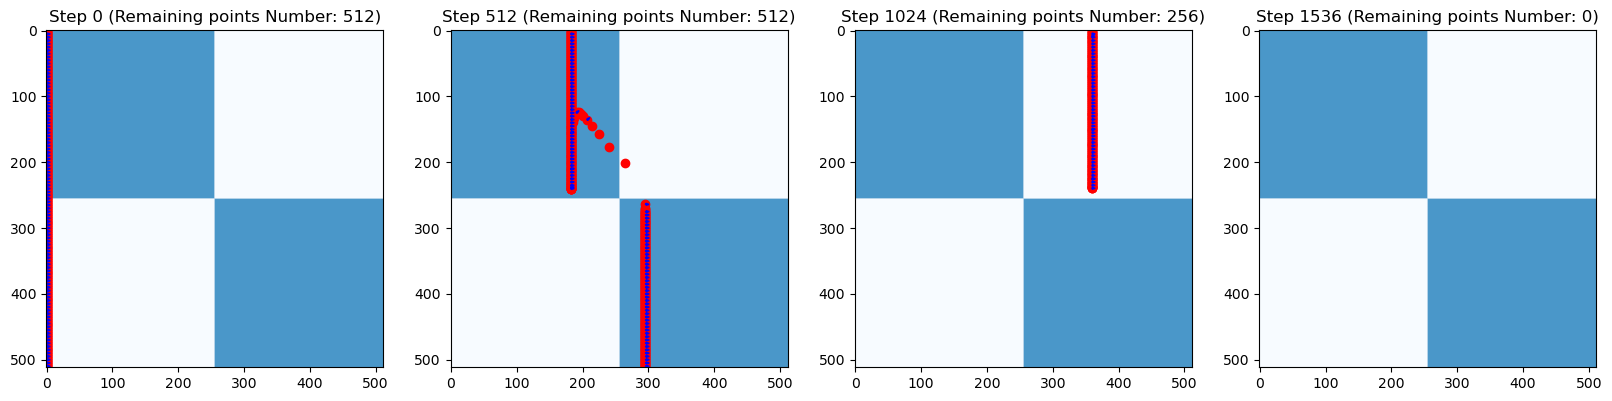

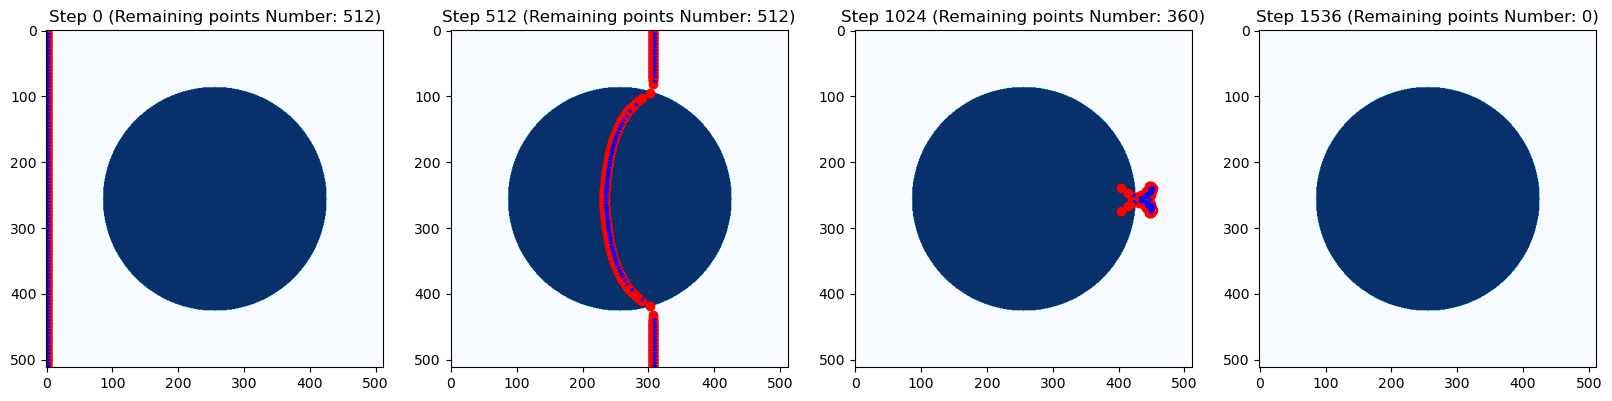

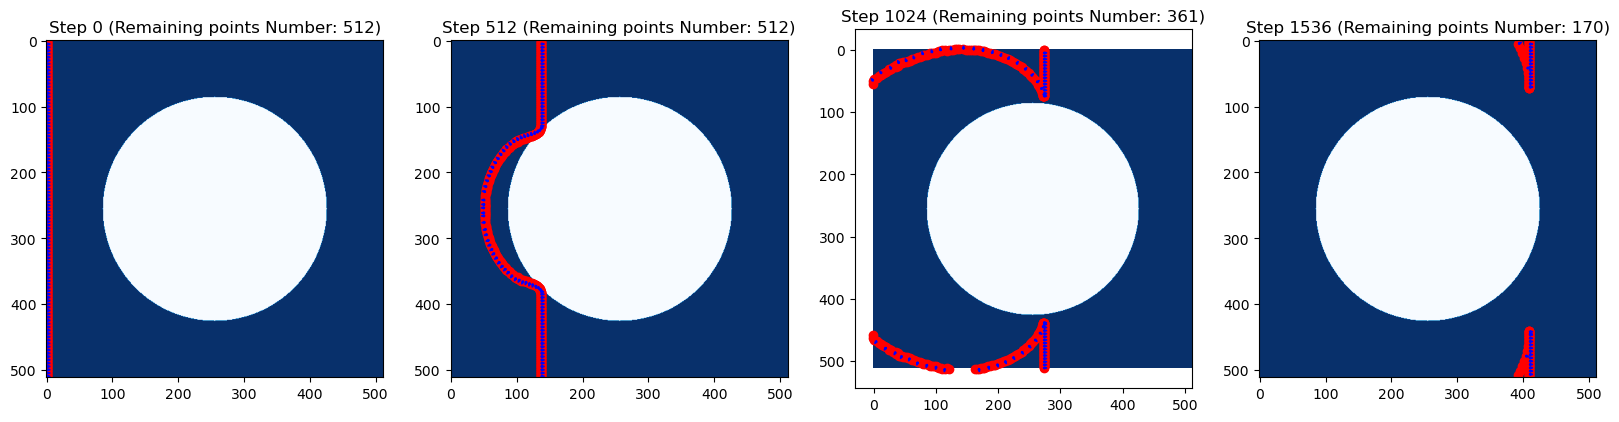

In [6]:
def update_wavefront_points(pos: list[tuple], dir: list[tuple], IOR: np.ndarray, IOR_grad: tuple[np.ndarray, np.ndarray], delta_t: float) -> tuple[list[tuple], list[tuple]]:
    new_pos = []
    new_dir = []
    grad_x_ior, grad_y_ior = IOR_grad
    for (x, y), (vx, vy) in zip(pos, dir):
        if 0 <= int(y) < IOR.shape[0] and 0 <= int(x) < IOR.shape[1]:
            n = IOR[int(y), int(x)]
            
            # x_i+1 = x_i + delta_t * v_i / n^2
            # v_i+1 = v_i + delta_t * grad_n / n
            # calculate the new position
            new_x = x + delta_t * (vx / (n**2))
            new_y = y + delta_t * (vy / (n**2))

            # calculate the new direction
            nx = grad_x_ior[int(y), int(x)]
            ny = grad_y_ior[int(y), int(x)]
            new_vx = vx + delta_t * (nx / n)
            new_vy = vy + delta_t * (ny / n)

            new_pos.append((new_x, new_y))
            new_dir.append((new_vx, new_vy))

        else:
            pass

    return new_pos, new_dir

def simulate_wavefront_propagation_points(cur_IOR: np.ndarray, inital_wavefront_pos: list[tuple], initial_wavefront_dir: list[tuple], 
                                   num_steps=200, delta_t=1.0) -> tuple[list[list[tuple]], list[list[tuple]]]:
    wavefront_pos_list = [inital_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    cur_IOR_grad = compute_gradients(cur_IOR)
    for _ in range(num_steps):
        wavefront_positions, wavefront_directions = update_wavefront_points(wavefront_pos_list[-1], wavefront_dir_list[-1], cur_IOR, cur_IOR_grad, delta_t)
        wavefront_pos_list.append(wavefront_positions)
        wavefront_dir_list.append(wavefront_directions)
    return wavefront_pos_list, wavefront_dir_list

def visualize_wavefront_propagation_points(wavefront_pos_list: list[list[tuple]], wavefront_dir_list: list[list[tuple]], 
                                    cur_IOR: np.ndarray, num_show_images=5):
    # show the wavefront propagation in num_show_images steps between 0 and num_steps
    num_show_images = [i for i in range(0, num_steps + 1, num_steps // num_show_images)]

    plt.figure(figsize=(5 * len(num_show_images), 5))
    for i in num_show_images:
        plt.subplot(1, len(num_show_images), num_show_images.index(i) + 1)
        plt.imshow(cur_IOR, cmap='Blues', vmin=1.0, vmax=1.5)
        plt.scatter([p[0] for p in wavefront_pos_list[i]], [p[1] for p in wavefront_pos_list[i]], color='red')
        for j, (x, y) in enumerate(wavefront_pos_list[i]):
            if j != 0 and j % 5 == 0:
                plt.arrow(x, y, wavefront_dir_list[i][j][0], wavefront_dir_list[i][j][1], color='blue', head_width=3)        
        plt.title(f'Step {i} (Remaining points Number: {len(wavefront_pos_list[i])})')
    plt.show()


for key, value in ior_field_dict.items():
    wavefront_pos_list, wavefront_dir_list = simulate_wavefront_propagation_points(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)
    value['pos'] = wavefront_pos_list
    value['dir'] = wavefront_dir_list
    visualize_wavefront_propagation_points(wavefront_pos_list, wavefront_dir_list, value['ior'], num_show_images)

## 3. Calculate irradiance $\Delta E_{\omega}$

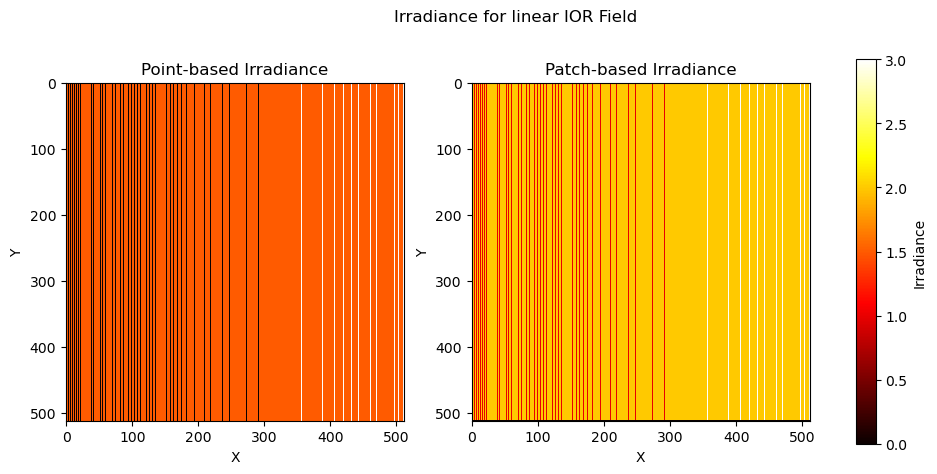

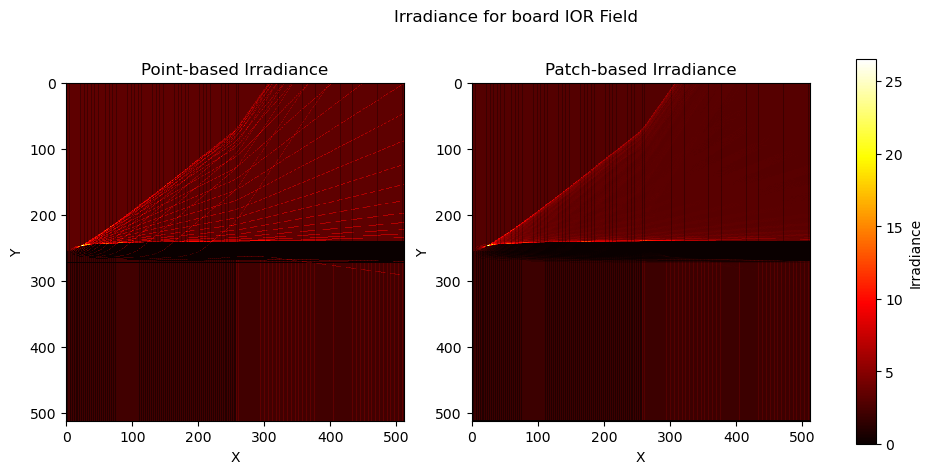

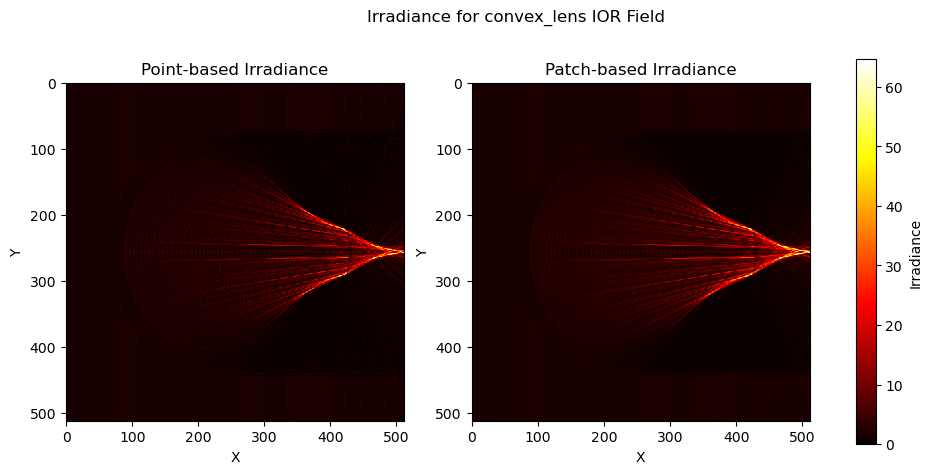

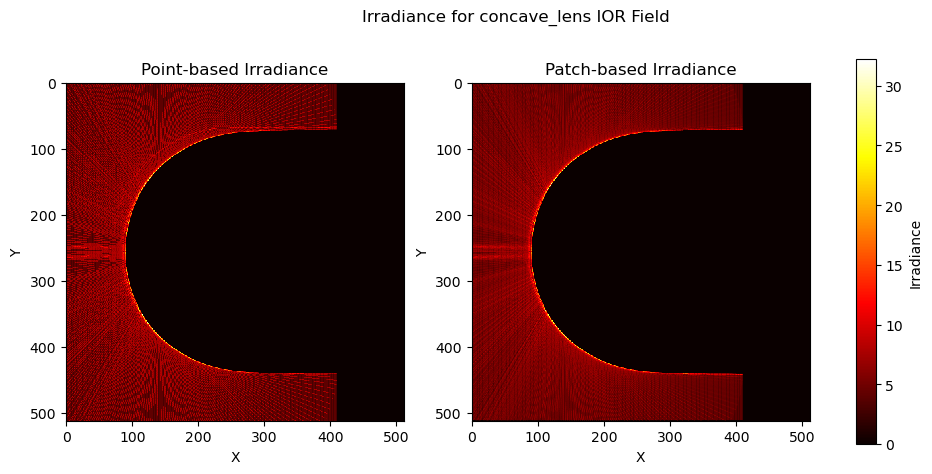

In [9]:
def compute_irradiance_points(wavefront_pos_list: list[list[tuple]], field_size: int, irradiance_grid_size: int|None = None) -> np.ndarray:
    irradiance = np.zeros((field_size, field_size))
    for pos_list in wavefront_pos_list:
        for x, y in pos_list:
            if 0 <= int(y) < field_size and 0 <= int(x) < field_size:
                irradiance[int(y), int(x)] += 1
    return irradiance

def compute_irradiance_patches(wavefront_patch_list: list[list[Patch]], field_size: int) -> np.ndarray:
    irradiance = np.zeros((field_size, field_size))
    for patch_list in wavefront_patch_list:
        for patch in patch_list:
            mid_x, mid_y = patch.mid_pos()
            
            # Compute the voxel coordinates of the patch midpoint
            voxel_x, voxel_y = int(mid_x), int(mid_y)
            
            # Check if the voxel coordinates are within the field boundaries
            if 0 <= voxel_x < field_size and 0 <= voxel_y < field_size:
                # Update the irradiance for the voxel containing the patch midpoint
                irradiance[voxel_y, voxel_x] += patch.energy    
    return irradiance

def visualize_irradiance(irradiance1: np.ndarray, irradiance2: np.ndarray, title: str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(irradiance1, cmap='hot', interpolation='nearest')
    ax1.set_title('Point-based Irradiance')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    
    im = ax2.imshow(irradiance2, cmap='hot', interpolation='nearest')
    ax2.set_title('Patch-based Irradiance')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    
    fig.colorbar(im, ax=[ax1, ax2], label='Irradiance')
    fig.suptitle(title)
    plt.show()

for key, value in ior_field_dict.items():
    simple_irradiance = compute_irradiance_points(value['pos'], field_size) #  np.zeros((field_size, field_size)) #  
    patch_irradiance = compute_irradiance_patches(value['patches_list'], field_size)
    visualize_irradiance(simple_irradiance, patch_irradiance, f'Irradiance for {key} IOR Field')
    
    value['irradiance'] = patch_irradiance
    value['simp_irradiance'] = simple_irradiance

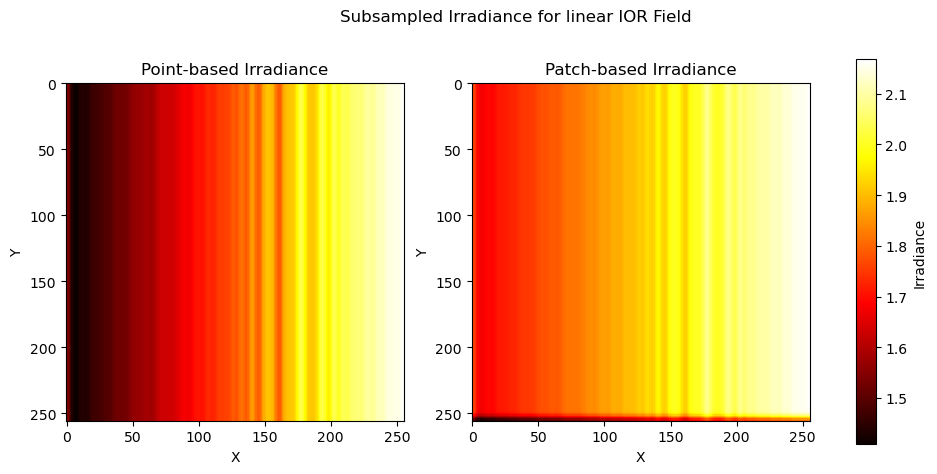

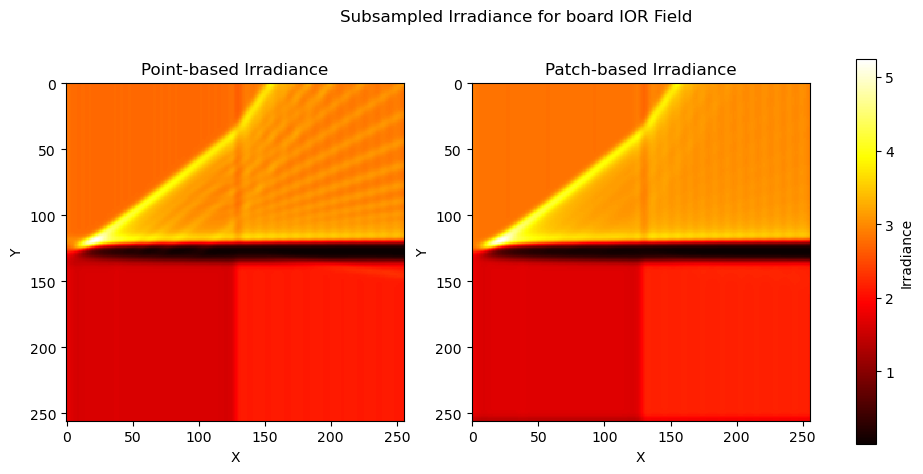

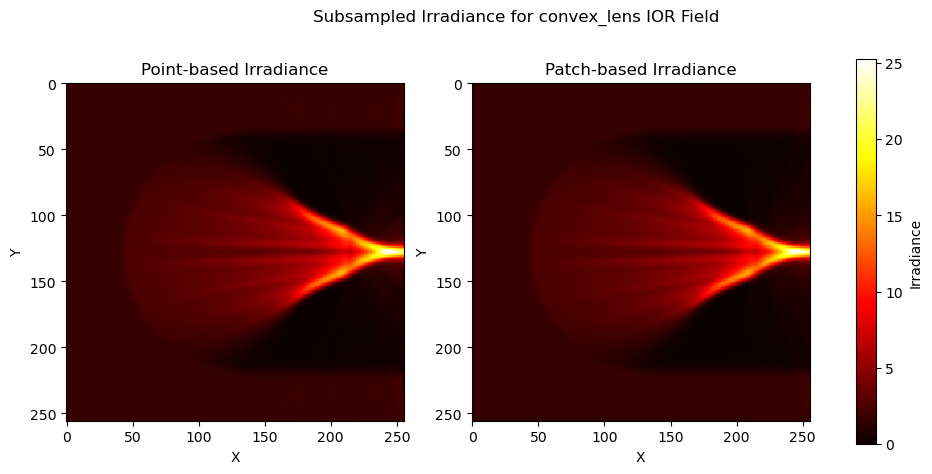

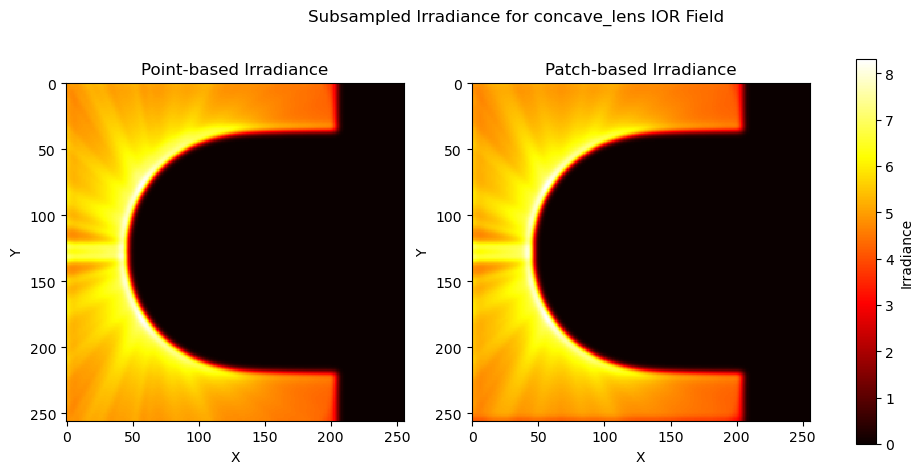

In [12]:
for key, value in ior_field_dict.items():
    
    irradiance = value['irradiance']
    simple_irradiance = value['simp_irradiance']
    
    # Gaussian filter the irradiance
    filtered_irradiance = ndimage.gaussian_filter(irradiance, sigma=5.0)
    # Subsample each irradiance to 256*256 using library function
    subsampled_irradiance = ndimage.zoom(filtered_irradiance, 0.5, order=1)

    simp_filtered_irradiance = ndimage.gaussian_filter(simple_irradiance, sigma=5.0)
    simp_subsampled_irradiance = ndimage.zoom(simp_filtered_irradiance, 0.5, order=1)

    visualize_irradiance(simp_subsampled_irradiance, subsampled_irradiance, f'Subsampled Irradiance for {key} IOR Field')

## 4. Train on Neural network

In [ ]:
tester = 'concave_lens'
irradiance = ior_field_dict[tester]['irradiance']

In [ ]:
class IrradianceNet(nn.Module):
    def __init__(self):
        super(IrradianceNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

def prepare_data(irradiance: np.ndarray, train_ratio=0.8) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    x = np.arange(irradiance.shape[0])
    y = np.arange(irradiance.shape[1])
    X, Y = np.meshgrid(x, y)
    inputs = np.stack((X, Y), axis=-1).reshape(-1, 2)
    targets = irradiance.flatten()

    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    targets = torch.tensor(targets, dtype=torch.float32).to(device)

    # 随机打乱索引
    indices = torch.randperm(len(inputs))
    inputs = inputs[indices]
    targets = targets[indices]

    # 划分训练集和验证集
    train_size = int(train_ratio * len(inputs))
    train_inputs, val_inputs = inputs[:train_size], inputs[train_size:]
    train_targets, val_targets = targets[:train_size], targets[train_size:]

    return train_inputs, val_inputs, train_targets, val_targets

def train_model(model: IrradianceNet, train_inputs: torch.Tensor, val_inputs: torch.Tensor, train_targets: torch.Tensor, val_targets: torch.Tensor, 
                num_epochs=2000, batch_size=1024, patience=400):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(train_inputs), batch_size):
            batch_inputs = train_inputs[i:i+batch_size]
            batch_targets = train_targets[i:i+batch_size]
            
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break
        
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    assert best_model is not None
    model.load_state_dict(best_model)
    return model

In [ ]:
def generate_irradiance_field(model, size=100):
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)
    coords = np.stack((X, Y), axis=-1).reshape(-1, 2)
    
    with torch.no_grad():
        inputs = torch.tensor(coords, dtype=torch.float32).to(device)
        predictions = model(inputs).cpu().numpy()
    
    return predictions.reshape(size, size)

def visualize_irradiance_fields(original_irradiance, predicted_irradiance):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_irradiance, cmap='viridis')
    plt.colorbar(label='Irradiance')
    plt.title('Original Irradiance Field')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_irradiance, cmap='viridis')
    plt.colorbar(label='Irradiance')
    plt.title('Predicted Irradiance Field')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

train_inputs, val_inputs, train_targets, val_targets = prepare_data(irradiance)
model = IrradianceNet().to(device)
model = train_model(model, train_inputs, val_inputs, train_targets, val_targets)
predicted_irradiance = generate_irradiance_field(model)
visualize_irradiance_fields(irradiance, predicted_irradiance)

In [ ]:
def predict_irradiance_at_position(model, x, y):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor([[x, y]], dtype=torch.float32).to(device)
        return model(input_tensor).item()
    
x, y = 10, 70
predicted_value = predict_irradiance_at_position(model, x, y)
print(f'Predicted irradiance at position ({x}, {y}): {predicted_value:.4f}')

In [ ]:
def get_model_size(model: IrradianceNet):
    def get_model_size_params(model):
        param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
        buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
        return param_size + buffer_size

    def get_model_size_file(model):
        import tempfile
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            torch.save(model.state_dict(), temp_file.name)
            size_file = os.path.getsize(temp_file.name)
        os.remove(temp_file.name)
        return size_file
    
    def format_size(size_bytes):
        return f"{size_bytes} Bytes"

    size_params = get_model_size_params(model)
    size_file = get_model_size_file(model)

    size_res = f"Model size (parameters): {format_size(size_params)} - " + \
            f"(saved file): {format_size(size_file)}"

    return size_res

get_model_size(model)

In [ ]:
# def train_and_visualize(simple_irradiance, patch_irradiance):
#     train_inputs, val_inputs, train_targets, val_targets = prepare_data(simple_irradiance)
#     model = IrradianceNet().to(device)
#     model = train_model(model, train_inputs, val_inputs, train_targets, val_targets)
#     predicted_simple_irradiance = generate_irradiance_field(model)

#     train_inputs, val_inputs, train_targets, val_targets = prepare_data(patch_irradiance)
#     model = IrradianceNet().to(device)
#     model = train_model(model, train_inputs, val_inputs, train_targets, val_targets)
#     predicted_patch_irradiance = generate_irradiance_field(model)
    
#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
#     ax1.imshow(simple_irradiance, cmap='hot', interpolation='nearest')
#     ax1.set_title('Original point-based irradiance')

#     ax2.imshow(predicted_simple_irradiance, cmap='hot', interpolation='nearest')
#     ax2.set_title('Predicted point-based irradiance')

#     ax3.imshow(patch_irradiance, cmap='hot', interpolation='nearest')
#     ax3.set_title('Original patch-based irradiance')

#     ax4.imshow(predicted_patch_irradiance, cmap='hot', interpolation='nearest')
#     ax4.set_title('Predicted patch-based irradiance')

#     plt.tight_layout()
#     plt.show()

# for i, (key, value) in enumerate(ior_field_dict.items()):
#     simple_irradiance = compute_irradiance_points(value['pos'], field_size)
#     patch_irradiance = compute_irradiance_patches(value['patches_list'], field_size)
    
#     train_and_visualize(simple_irradiance, patch_irradiance)

In [ ]:
# def train_and_visualize(irradiance, title):
#     train_inputs, val_inputs, train_targets, val_targets = prepare_data(irradiance)
#     model = IrradianceNet().to(device)
#     model = train_model(model, train_inputs, val_inputs, train_targets, val_targets)
#     predicted_irradiance = generate_irradiance_field(model)
#     print(title)
#     visualize_irradiance_fields(irradiance, predicted_irradiance)

# for key, value in ior_field_dict.items():
#     simple_irradiance = compute_irradiance_points(value['pos'], field_size)
#     patch_irradiance = compute_irradiance_patches(value['patches_list'], field_size)

#     print(f"Training and visualizing for element: {key}")
    
#     print("Simple Irradiance:")
#     train_and_visualize(simple_irradiance, f"Element {key} - Simple Irradiance")
    
#     print("Patch Irradiance:")
#     train_and_visualize(patch_irradiance, f"Element {key} - Patch Irradiance")
    
#     print("-" * 50)


## (vector field of local light directions $l(x)$)

In [ ]:
def compute_light_directions_patches(wavefront_patch_list: list[list[Patch]], field_size: int) -> np.ndarray:
    light_directions = np.zeros((field_size, field_size, 2))
    max_irradiance = np.zeros((field_size, field_size))

    for patch_list in wavefront_patch_list:
        for patch in patch_list:
            mid_x, mid_y = patch.mid_pos()
            start_vx, start_vy = patch.start_dir
            
            # Compute the voxel coordinates of the patch midpoint
            voxel_x, voxel_y = int(mid_x), int(mid_y)
            
            # Check if the voxel coordinates are within the field boundaries
            if 0 <= voxel_x < field_size and 0 <= voxel_y < field_size:
                # Normalize the direction vector
                direction_norm = np.linalg.norm([start_vx, start_vy])
                normalized_direction = [start_vx / direction_norm, start_vy / direction_norm]
                
                # Update the light direction and max irradiance for the voxel containing the patch midpoint
                if patch.energy > max_irradiance[voxel_y, voxel_x]:
                    light_directions[voxel_y, voxel_x] = normalized_direction
                    max_irradiance[voxel_y, voxel_x] = patch.energy

    return light_directions

def visualize_light_directions(light_directions: np.ndarray, title: str):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Compute the coordinates of the arrow positions
    y, x = np.mgrid[0:light_directions.shape[0], 0:light_directions.shape[1]]
    
    # Extract the x and y components of the light directions
    dir_x = light_directions[:, :, 0]
    dir_y = light_directions[:, :, 1]
    
    # Plot the light direction arrows
    ax.quiver(x, y, dir_x, dir_y, angles='xy', scale_units='xy', scale=1.1, color='blue')    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.set_aspect('equal')    
    plt.tight_layout()
    plt.show()


for key, value in ior_field_dict.items():
    value['dir_vec'] = compute_light_directions_patches(value['patches_list'], field_size)
    # visualize_light_directions(value['dir_vec'], f'Light Directions - {key}')

## 5. Store irradiance into quad tree

In [ ]:
test_irradiance = ior_field_dict[tester]['irradiance']

In [ ]:
class Node:
    def __init__(self, val: int = 0, top_left=None, top_right=None, bottom_left=None, bottom_right=None):
        self.val = val
        self.top_left = top_left
        self.top_right = top_right
        self.bottom_left = bottom_left
        self.bottom_right = bottom_right
    
    @property
    def is_leaf(self):
        return all(child is None for child in (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
    
    def __repr__(self):
        return self._repr_recursive()

    def _repr_recursive(self, depth=0, max_depth=2):
        indent = "  " * depth
        if self.is_leaf:
            return f"{indent}Node(val={self.val})"
        else:
            if depth >= max_depth:
                return f"{indent}Node(...)"
            children_repr = ",\n".join(self._repr_recursive_child(child, depth + 1, max_depth) for child in 
                                       (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
            return f"{indent}Node(\n{children_repr})"

    def _repr_recursive_child(self, child, depth, max_depth):
        return "  " * depth + "None" if child is None else child._repr_recursive(depth, max_depth)

class QuadTree:
    def __init__(self, threshold: int = 0):
        self.threshold = threshold
        self.grid_size = 0
        self.root = None
    
    def construct(self, grid: np.ndarray) -> None:
        self.root = self._build_tree(grid, 0, 0, grid.shape[0])
        self.grid_size = grid.shape[0]
    
    def _build_tree(self, grid: np.ndarray, i: int, j: int, size: int) -> Node:
        if self._is_homogeneous(grid, i, j, size):
            return Node(grid[i, j])

        half_size = size // 2
        top_left = self._build_tree(grid, i, j, half_size)
        top_right = self._build_tree(grid, i, j + half_size, half_size)
        bottom_left = self._build_tree(grid, i + half_size, j, half_size)
        bottom_right = self._build_tree(grid, i + half_size, j + half_size, half_size)
        
        if top_left.is_leaf and top_right.is_leaf and bottom_left.is_leaf and bottom_right.is_leaf:
            values = {node.val for node in (top_left, top_right, bottom_left, bottom_right)}
            if len(values) == 1:
                return Node(values.pop())
        
        return Node(top_left=top_left, top_right=top_right, bottom_left=bottom_left, bottom_right=bottom_right)
    
    def _is_homogeneous(self, grid: np.ndarray, i: int, j: int, size: int) -> bool:
        return np.ptp(grid[i:i+size, j:j+size]) <= self.threshold

    def query(self, x: int, y: int) -> int:
        return self._query(self.root, 0, 0, self.grid_size, x, y)

    def _query(self, node: Node | None, i: int, j: int, size: int, x: int, y: int) -> int:
        if node is None:
            raise ValueError("QuadTree is empty. Maybe you forgot to construct it?")
        
        if node.is_leaf:
            return node.val

        half_size = size // 2
        if x < i + half_size:
            if y < j + half_size:
                return self._query(node.bottom_left, i, j, half_size, x, y)
            else:
                return self._query(node.top_left, i, j + half_size, half_size, x, y)
        else:
            if y < j + half_size:
                return self._query(node.bottom_right, i + half_size, j, half_size, x, y)
            else:
                return self._query(node.top_right, i + half_size, j + half_size, half_size, x, y)
    
    def __len__(self):
        return self._count_nodes(self.root)
    
    def _count_nodes(self, node: Node | None) -> int:
        if node is None:
            return 0
        return 1 + sum(self._count_nodes(child) for child in 
                       (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def __sizeof__(self):
        return self._calculate_memory_usage(self.root)
    
    def _calculate_memory_usage(self, node: Node | None) -> int:
        if node is None:
            return 0
        return sys.getsizeof(node) + sum(self._calculate_memory_usage(child) for child in 
                                         (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def visualize(self, figsize=(12, 12)):
        plt.figure(figsize=figsize)
        self._visualize_node(self.root, 0, 0, self.grid_size)
        plt.axis('equal')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.tight_layout()
        plt.title('Quad Tree Visualization')
        plt.show()
        
    def _visualize_node(self, node: Node | None, x: float, y: float, size: float):
        if node is None:
            return
        if node.is_leaf:
            rect = patches.Rectangle((x, y), size, size, linewidth=1, edgecolor='black', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x + size / 2, y + size / 2, str(int(node.val)), ha='center', va='center')
        else:
            half_size = size / 2
            self._visualize_node(node.top_left, x, y + half_size, half_size)
            self._visualize_node(node.top_right, x + half_size, y + half_size, half_size)
            self._visualize_node(node.bottom_left, x, y, half_size)
            self._visualize_node(node.bottom_right, x + half_size, y, half_size)



quad_tree = QuadTree(threshold=4) 
quad_tree.construct(test_irradiance)

value = quad_tree.query(60, 60)
print(f"Query value at (0, 99): {value}")

node_count = len(quad_tree)
print(f"Number of nodes: {node_count}")

memory_usage = sys.getsizeof(quad_tree)
print(f"Memory Usage: {memory_usage} bytes")
print(f"In comparison, NumPy Storage Usage: {test_irradiance.nbytes} bytes")

quad_tree.visualize()

In [ ]:
# plt show test_irradiance and write its each element specific int value
plt.figure(figsize=(20, 20))
plt.imshow(test_irradiance, cmap='hot', interpolation='nearest')
for i in range(test_irradiance.shape[0]):
    for j in range(test_irradiance.shape[1]):
        plt.text(j, i, str(int(test_irradiance[i, j])), ha='center', va='center', color='black', fontsize=7)
plt.colorbar(label='Irradiance')
plt.title('Test Irradiance')
plt.show()